## Librerias y Funciones

In [64]:
import pandas as pd
import numpy as np
import math
import re
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
#import plotly.express as px
#import plotly.graph_objects as go
from scipy import stats
from scipy.stats import spearmanr
from sklearn.preprocessing import LabelEncoder

In [89]:
#FUNCION PARA OBTENER CORRELACIONES DE PUNTO BISERIAL
def get_corr_biserial_point(target_var:str, vars:list, vars_type:str):
    #Dataframe para alojar correlaciones
    df_corr = pd.DataFrame(index=vars, columns=['correlation'])

    #Lista de correlaciones de punto biserial
    corr_list = [stats.pointbiserialr(df[target_var], df[var]) for var in vars]
    
    #Ciclo iterativo para cargar datos en el dataframe
    for var, corr in zip(vars, corr_list):
        df_corr.loc[var, 'correlation'] = corr.statistic

    #Valor maximo
    max_value = df_corr.correlation.abs().round(2).max()
    max_value = np.ceil(max_value*10)/10    

    #Ploteo del grafico
    plot_correlation(df_corr, vars_type, max_value)


#FUNCION PARA PLOTEAR CORRELACIONES
def plot_correlation(df_corr:pd.DataFrame, vars_type:str, limit_value:float):
    colors = ['#000E9E' if corr < 0 else '#3DB2DA' for corr in df_corr.correlation]
    plt.style.use("bmh")
    plt.figure(figsize=(8,5))  
    sns.barplot(x=df_corr.correlation, y=df_corr.index, hue=df_corr.index, palette=colors)
    plt.title(f'Correlacion de variable objetivo con variables {vars_type}', fontsize=14)
    plt.xlabel('Coeficiente de correlacion')
    plt.ylabel(f'Variables {vars_type}')
    plt.xlim(-1*limit_value, limit_value)
    plt.tight_layout()
    plt.show()
    plt.style.use("default")  

### APERTURA DE ARCHIVO

In [66]:
df = pd.read_csv('Hotel_Reservations_clean.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36133 entries, 0 to 36132
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Booking_ID              36133 non-null  object 
 1   num_adults              36133 non-null  int64  
 2   num_children            36133 non-null  int64  
 3   weekend_nights          36133 non-null  int64  
 4   week_nights             36133 non-null  int64  
 5   total_nights            36133 non-null  int64  
 6   meal_plan               36133 non-null  object 
 7   car_parking             36133 non-null  int64  
 8   room_type               36133 non-null  object 
 9   lead_time               36133 non-null  int64  
 10  arrival_year            36133 non-null  int64  
 11  arrival_month           36133 non-null  int64  
 12  arrival_day             36133 non-null  int64  
 13  arrival_season          36133 non-null  object 
 14  mkt_segment             36133 non-null

### Analisis de correlaciones

#### Separacion de variables segun su tipo

In [67]:
numeric_var = ['num_adults', 'num_children', 'weekend_nights','week_nights',
                'total_nights', 'lead_time','num_prev_cancellations',
                'num_prev_not_canceled', 'avg_price_room', 'num_sp_requests']

nominal_var = ['repeated_guest', 'car_parking', 'arrival_season_cod', 'mkt_segment_cod']

ordinal_var = ['meal_plan_cod','room_type_cod']

#### Matriz de correlacion (Pearlson)

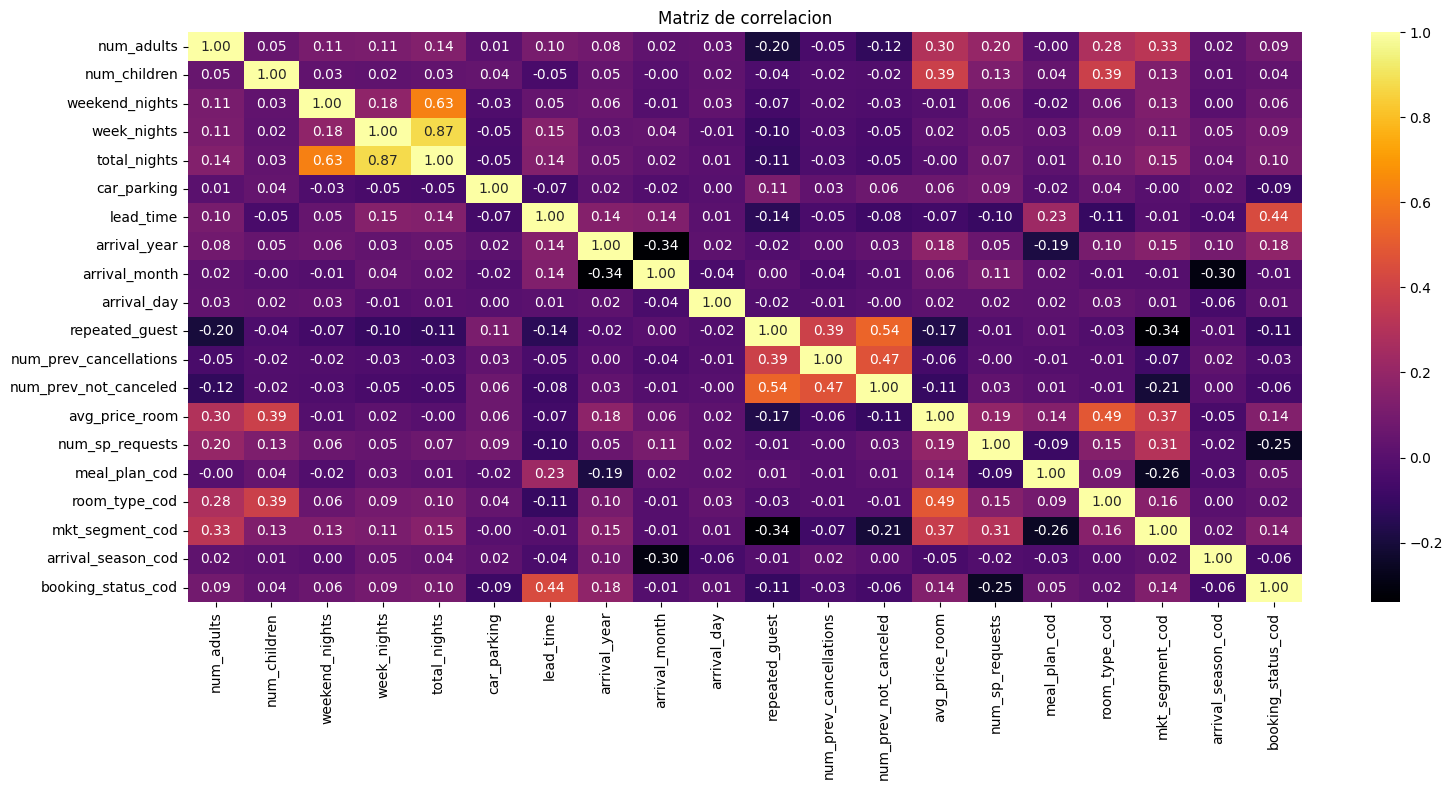

In [68]:
matrix = df.corr(numeric_only=True)
plt.figure(figsize=(16,8))
sns.heatmap(matrix, fmt='.2f', annot=True, cmap='inferno')
plt.title('Matriz de correlacion')
plt.tight_layout()
plt.show()

#### Correlacion de variable ***booking_status*** con variables cuantitativas y ordinales

Se utiliza el ***coeficiente de correlacion punto biserial*** para determinar la relacion entre las variables cuantitativas y la variable de interes ***booking_status*** que es de tipo nominal dicotomica.

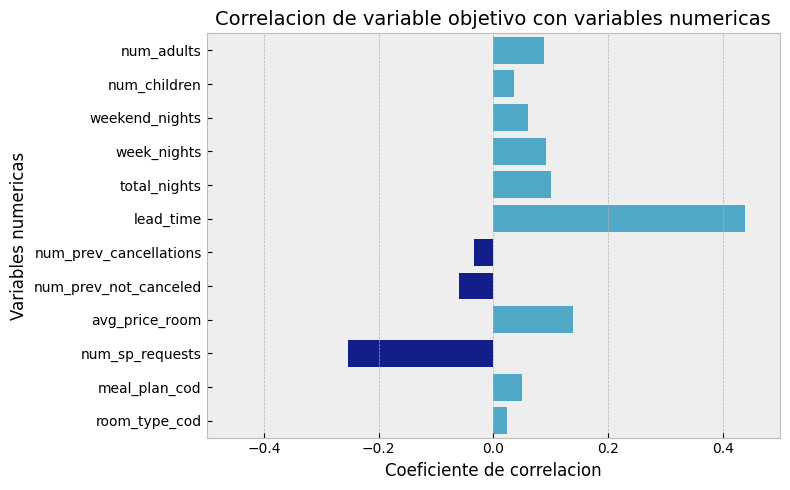

In [90]:
get_corr_biserial_point('booking_status_cod', numeric_var+ordinal_var, 'numericas')

#### Correlacion de variable objetivo ***booking_status*** con variables de origen nominal

Se utiliza la ***coeficiente de contingencia*** para determinar la relacion entre las variables nominales y la variable de interes ***booking_status*** que es de tipo nominal dicotomica. Para ello se obtiene el estadisitico de prueba ***Chi cuadrado*** utilizando la libreria ***scipy*** para posteriormente obtener el coeficiente con la formula que se muestra acontinuacion:
$$
C = \sqrt{\frac{x^2}{N+x^2}}
$$
X²: Estadistico Chi²<br>
N: Cantidadad de observaciones totales<br>
C: coeficiente de contingencia<br>